# Pretrained XGB Model Demo

## Load in Libaries

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [2]:
import os
import numpy as np
import xgboost as xgb
from sklearn import metrics
from src.preprocessing.esa_compress import compress_esa, decompress_esa
from src.preprocessing.load_landsat_esa import return_xy_npa, y_npa_to_xr, return_x_y_da
from src.visualisation.ani import animate_prediction

In [ ]:
ls -lash /gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/inputs/

## Load in Data and set params

### set param

In [3]:
cfd = {
    "start_year_i": 8, # remove pre-2000 data as esa CCI unreliable
    "mid_year_i": 19,  # This parameter normally controls the train/test split
    "end_year_i": 24,
    "take_esa_coords": True, # Use the 300m resolution of ESA CCI
    "use_ffil": True,
    "use_mfd": False,
    "use_ir": True,
    "prefer_remake": False,
}

x_da, y_da = return_x_y_da(
    take_esa_coords=cfd["take_esa_coords"],
    use_ffil=cfd["use_ffil"],
    use_mfd=cfd["use_mfd"],
    use_ir=cfd["use_ir"],
    prefer_remake=cfd["prefer_remake"]
)  # load preprocessed data from netcdfs

['/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/inputs/take_esa_coords_True_use_mfd_False_use_ffil_True_use_ir_True_x.nc', '/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/inputs/take_esa_coords_True_use_mfd_False_use_ffil_True_use_ir_True_y.nc']
x/y values premade. Reusing them.
'clip'  0.00474 s

'return_x_y_da'  0.39327 s



### Look at X values

In [4]:
x_da

<xarray.DataArray 'norm_refl' (y: 681, x: 1086, band: 6, year: 24, mn: 4)>
[425990016 values with dtype=float32]
Coordinates:
  * x        (x) float64 28.41 28.41 28.41 28.42 ... 31.41 31.42 31.42 31.42
  * y        (y) float64 52.43 52.43 52.43 52.43 ... 50.55 50.55 50.55 50.55
  * band     (band) object 'red' 'green' 'blue' 'nir' 'swir1' 'swir2'
  * year     (year) int64 1992 1993 1994 1995 1996 ... 2011 2012 2013 2014 2015
  * mn       (mn) object 'JFM' 'AMJ' 'JAS' 'OND'
Attributes:
    description:  Normalized reflectance at chern for JFM. Bands order ['B3',...
    bands:        ['B3', 'B2', 'B1']

### Look at Y values

In [5]:
y_da

<xarray.DataArray 'esa_cci' (year: 24, y: 681, x: 1086)>
[17749584 values with dtype=uint8]
Coordinates:
    band     int64 ...
  * y        (y) float64 52.43 52.43 52.43 52.43 ... 50.55 50.55 50.55 50.55
  * x        (x) float64 28.41 28.41 28.41 28.42 ... 31.41 31.42 31.42 31.42
  * year     (year) int64 1992 1993 1994 1995 1996 ... 2011 2012 2013 2014 2015
Attributes:
    transform:      [ 2.77777778e-03  0.00000000e+00  2.84055556e+01  0.00000...
    crs:            +init=epsg:4326
    res:            [0.00277778 0.00277778]
    is_tiled:       0
    nodatavals:     0.0
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area

## Load in Model

In [6]:
import shutil
from src.constants import GWS_DATA_DIR
direc = GWS_DATA_DIR / "xgb-demo"
# if not os.path.exists(direc):
#    os.mkdir(direc)

original_model_file = "/home/users/sithom/gtc-biodiversity/wandb/run-20210312_090016-13hoa5pu/files/dazzling-galaxy-57_xgb.model"
# original_model_file = "/home/users/sithom/gtc-biodiversity/wandb/run-20210304_012917-1u5o038w/files/lyric-haze-30_xgb.model"
model_file = direc / "demo_xgb.model"
video_name = "test.mp4"
shutil.copy(original_model_file, model_file)

PosixPath('/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/xgb-demo/demo_xgb.model')

In [7]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model(model_file)  # load data

## Predict labels with model
Need to load the data into an acceptable `numpy` format, and pass to `xgboost` 
to make the predictions. Step takes about 5 minutes.

In [8]:
x_all, y_all = return_xy_npa(
    x_da, y_da, year=range(cfd["start_year_i"], cfd["end_year_i"])
)  # all data as numpy.
xg_all = xgb.DMatrix(
    x_all, label=compress_esa(y_all)
)  # pass all data to xgb data matrix
y_pr_all = decompress_esa(
    bst.predict(xg_all)
)  # predict whole time period using model
y_pr_da = y_npa_to_xr(
    y_pr_all, y_da.isel(year=range(cfd["start_year_i"], cfd["end_year_i"]))
)  # transform full prediction to dataarray.
print("\n Finished model predict")

'return_xy_npa'  177.13352 s

'y_npa_to_xr'  0.01159 s


 Finished model predict


## Animate the results

In [9]:
animate_prediction(
    x_da.isel(year=range(cfd["start_year_i"], cfd["end_year_i"])),
    y_da.isel(year=range(cfd["start_year_i"], cfd["end_year_i"])),
    y_pr_da,
    video_path=str(video_name),
)  # animate prediction vs inputs.

test.mp4:   0%|          | 0/16 [00:00<?, ?it/s]findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
test.mp4: 100%|██████████| 16/16 [00:30<00:00,  1.91s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (720, 1224) to (720, 1232) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video test.mp4 made.
'animate_prediction'  32.17718 s



In [10]:
from IPython.display import Video
Video(video_name)

In [11]:
print("Classification accuracy: {}".format(metrics.accuracy_score(y_all, y_pr_all)))

Classification accuracy: 0.6485326360324839


In [12]:
print(metrics.classification_report(y_all, y_pr_all))

/home/users/sithom/gtc-biodiversity/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/users/sithom/gtc-biodiversity/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.66      0.07      0.13     21792
          10       0.69      0.87      0.77   4441749
          11       0.55      0.09      0.16    697807
          30       0.63      0.01      0.02    369774
          40       0.76      0.02      0.03    146967
          60       0.44      0.63      0.51    922962
          61       0.99      0.13      0.23      3679
          70       0.72      0.81      0.76   3029563
          80       0.00      0.00      0.00        32
          90       0.38      0.38      0.38    913569
         100       0.35      0.02      0.03    443810
         110       1.00      0.39      0.56      1388
         130       0.72      0.08      0.14    225094
         150       0.99      0.57      0.72      2640
         160       0.61      0.28      0.38    139735
         180       0.90      0.26      0.40     29463
         190       0.68      0.38      0.49    154395
         200       0.98    

/home/users/sithom/gtc-biodiversity/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#  Make Higher Quality Image

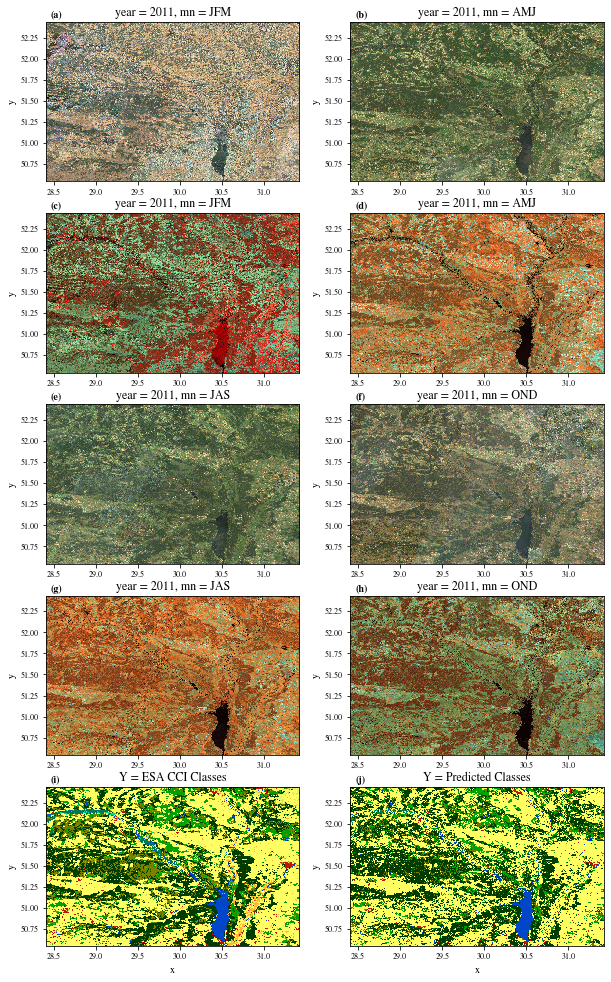

In [29]:
import xarray as xr
import matplotlib.pyplot as plt
from src.data_loading.landcover_plot_utils import classes_to_rgb
from src.plot_settings import ps_defaults, label_subplots
ps_defaults(use_tex=True)

index=19

if len(x_da.band.values) == 3:
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 10))
elif len(x_da.band.values) == 6:
    fig, (
        (ax1, ax2),
        (ax1b, ax2b),
        (ax3, ax4),
        (ax3b, ax4b),
        (ax5, ax6),
    ) = plt.subplots(5, 2, figsize=(10, 17))
else:
    assert False

x_da.isel(year=index, mn=0, band=slice(0, 3)).plot.imshow(ax=ax1)
x_da.isel(year=index, mn=1, band=slice(0, 3)).plot.imshow(ax=ax2)
x_da.isel(year=index, mn=2, band=slice(0, 3)).plot.imshow(ax=ax3)
x_da.isel(year=index, mn=3, band=slice(0, 3)).plot.imshow(ax=ax4)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("")

if len(x_da.band.values) == 6:
    x_da.isel(year=index, mn=0, band=slice(3, 6)).plot.imshow(ax=ax1b)
    x_da.isel(year=index, mn=1, band=slice(3, 6)).plot.imshow(ax=ax2b)
    x_da.isel(year=index, mn=2, band=slice(3, 6)).plot.imshow(ax=ax3b)
    x_da.isel(year=index, mn=3, band=slice(3, 6)).plot.imshow(ax=ax4b)
    for ax in [ax1b, ax2b, ax3b, ax4b]:
        ax.set_xlabel("")
    label_subplots([ax1, ax2, ax1b, ax2b, ax3, ax4, ax3b, ax4b, ax5, ax6], y_pos=1.07)
else:
    label_subplots([ax1, ax2, ax3, ax4, ax5, ax6])

xr.DataArray(
    data=classes_to_rgb(y_da.isel(year=index).values),
    dims=["y", "x", "band"],
    coords=dict(
        y=y_da.coords["y"].values,
        x=y_da.coords["x"].values,
        band=["red", "green", "blue"],
        Y="ESA CCI Classes",
    ),
).plot.imshow(ax=ax5)

xr.DataArray(
    data=classes_to_rgb(np.round_(y_pr_da.isel(year=index - 8)).values.astype("int16")),
    dims=["y", "x", "band"],
    coords=dict(
        y=y_da.coords["y"].values,
        x=y_da.coords["x"].values,
        band=["red", "green", "blue"],
        Y="Predicted Classes",
    ),
).plot.imshow(ax=ax6)


plt.savefig('2011-pred.png', dpi=600)

In [30]:
from xgboost import plot_tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.229374 to fit


<AxesSubplot:>

In [31]:
plot_tree(bst)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.229374 to fit


<AxesSubplot:>

In [33]:
xgb.to_graphviz(bst) #, num_trees=0, rankdir='LR')


# Looking at Feature importance

In [36]:
from xgboost import plot_importance
from src.plot_settings import set_dim

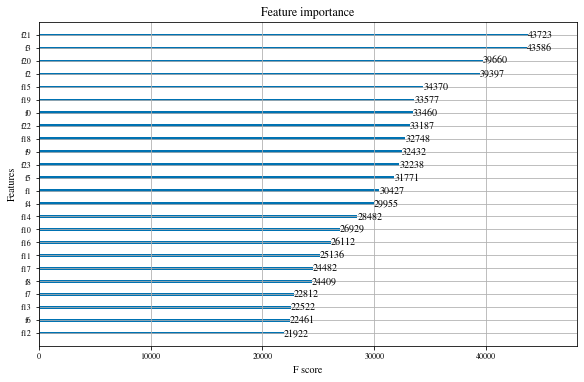

In [37]:
plot_importance(bst)
fig = plt.gcf()
set_dim(fig)

## Confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from src.preprocessing.esa_compress import compress_esa, decompress_esa, FORW_D, REV_D
from src.plot_settings import set_dim
from src.data_loading.landcover_plot_utils import ESA_CCI_CLASSES

In [31]:
ticks = np.array(range(0, compress_esa(y_all).max()+1))
class_list = decompress_esa(ticks).tolist()
ticks_list = ticks.tolist()

In [32]:
ticks_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [30]:
class_list

[0,
 10,
 11,
 30,
 40,
 60,
 61,
 70,
 80,
 90,
 100,
 110,
 130,
 150,
 160,
 180,
 190,
 200,
 201,
 210]

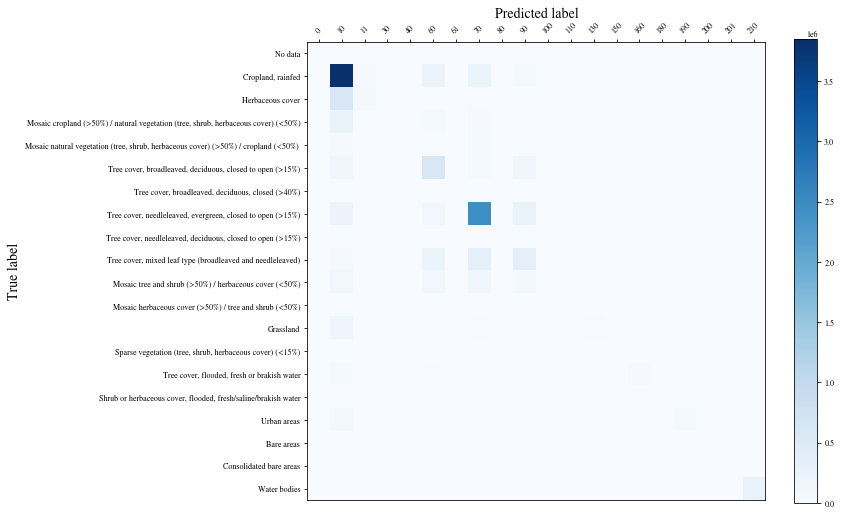

In [59]:
matrix = confusion_matrix(compress_esa(y_all), compress_esa(y_pr_all))

plt.clf()

# place labels at the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position("top")

# plot the matrix per se
plt.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)

# plot colorbar to the right
plt.colorbar()

fmt = "d"

# write the number of predictions in each bucket

"""
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

    # if background is dark, use a white number, and vice-versa
    plt.text(j, i, format(matrix[i, j], fmt),
         horizontalalignment="center",
         color="white" if matrix[i, j] > thresh else "black")      
"""

# tick_marks = np.arange(len(class_names))
plt.xticks(ticks_list, class_list, rotation=45)
plt.yticks(
    ticks_list, ESA_CCI_CLASSES.loc[class_list].LCCOwnLabel.tolist()
)  # class_list)
plt.tight_layout()
plt.ylabel("True label", size=14)
plt.xlabel("Predicted label", size=14)

fig = plt.gcf()
set_dim(fig, fraction_of_line_width=2, ratio=0.4)

In [54]:
ESA_CCI_CLASSES.loc[class_list].LCCOwnLabel.tolist()

['No data',
 'Cropland, rainfed',
 'Herbaceous cover',
 'Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%)',
 'Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%) ',
 'Tree cover, broadleaved, deciduous, closed to open (>15%)',
 'Tree cover, broadleaved, deciduous, closed (>40%)',
 'Tree cover, needleleaved, evergreen, closed to open (>15%)',
 'Tree cover, needleleaved, deciduous, closed to open (>15%)',
 'Tree cover, mixed leaf type (broadleaved and needleleaved)',
 'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)',
 'Mosaic herbaceous cover (>50%) / tree and shrub (<50%)',
 'Grassland',
 'Sparse vegetation (tree, shrub, herbaceous cover) (<15%)',
 'Tree cover, flooded, fresh or brakish water',
 'Shrub or herbaceous cover, flooded, fresh/saline/brakish water',
 'Urban areas',
 'Bare areas',
 'Consolidated bare areas',
 'Water bodies']